In [101]:
from sealrtc import *
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as opt
from scipy import signal
import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ol_values = np.load(joindata("openloop", "ol_f_1_z_stamp_03_11_2021_13_58_53.npy"))
dmc2wf = np.load(joindata("bestflats", "lodmc2wfe.npy"))
ol_values *= dmc2wf
fs = 100
nsteps = 10000
ident = SystemIdentifier(ol_values, fs=fs, N_vib_max=1)
klqg = ident.make_klqg_from_openloop()

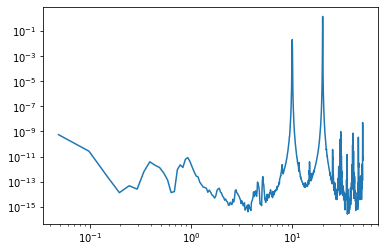

In [261]:
t, y = multivib(t=100, ws=2*np.pi*np.array([10, 20]), ks=[1e-3, 1e-4], sigmas=[0.01, 0.001], dt=0.01)
f, p = genpsd(y, dt=0.01)
plt.loglog(f, p)

In [262]:
find_psd_peaks(f, p)

array([20.01953125, 10.00976562])

In [218]:
def model_psd(freqs, f, k, sigma):
    phase = 2 * np.pi * freqs / fs
    a1, a2 = vib_coeffs(f, k)
    denom = np.abs(1 - a1 * np.exp(-1j * phase) - a2 * np.exp(-2j * phase))
    return np.log10(sigma ** 2 / fs / denom ** 2)


In [238]:
fcen = 20
kcen = 1e-3
s = 0.001
a1, a2 = vib_coeffs(fcen, kcen, fs=fs)
nsteps = 10000
x = np.zeros(nsteps,)
x[0], x[1] = np.random.normal(0, s, (2,))
for i in tqdm.trange(2, nsteps):
    x[i] = a1 * x[i-1] + a2 * x[i-2] + np.random.normal(0, s)
f, p = genpsd(x, dt=1/fs)

100%|██████████| 9998/9998 [00:00<00:00, 107336.77it/s]


In [147]:
"""def obj(X, fcen, freqs=f):
    k, sigma = X
    #return (model_psd(freqs, fcen, k, sigma) - p)
    f = 10 * np.log10(model_psd(freqs, fcen, k, sigma)) - 10 * np.log10(p)
    return f

def jac(X, fcen, freqs=f, fs=fs):
    k, sigma = X
    w = 2 * np.pi * freqs
    N = len(w)
    a1, a2 = vib_coeffs(fcen, k)
    Z = a1 ** 2 + a2 ** 2 + 2 * a1 * a2 * np.cos(w) - 2 * a1 * np.cos(w) - 2 * a2 * np.cos(2 * w)
    df_da1 = (10 / np.log(10)) * (1/Z) * (2*a1 + 2*a2 * np.cos(w) - 2*np.cos(w))
    df_da2 = (10 / np.log(10)) * (1/Z) * (2*a2 + 2*a1 * np.cos(w) - 2*np.cos(2*w))
    arg = 2 * np.pi * (fcen / fs) * np.sqrt(1 - k ** 2)
    da1_dk = -4 * np.pi * (fcen / fs) * np.cos(arg)
    da1_dk -= 4 * np.pi * (fcen / fs) * k * np.sqrt(1 - k ** 2) * np.sin(arg)
    da1_dk *= np.exp(-2 * k * np.pi * fcen / fs)
    da2_dk = 4 * np.pi * (fcen / fs) * np.exp(-4 * k * np.pi * fcen / fs)
    df_dk = df_da1 * da1_dk + df_da2 * da2_dk
    df_dsigma = -((10 / np.log(10)) / sigma) * np.ones(N)
    return np.column_stack((df_dk, df_dsigma)) 
    """

In [239]:
from lmfit import Model, Parameters
df = np.max(np.diff(f))
fit_params = Parameters()
fit_params.add('f', value=fcen, min=fcen-df, max=fcen+df)
fit_params.add('k', value=1e-4, min=1e-10, max=1)
fit_params.add('sigma', value=1e-1, min=1e-10, max=100)

In [240]:
psd_model = Model(model_psd)
res = psd_model.fit(np.log10(p), fit_params, freqs=f)
print(res.fit_report())

[[Model]]
    Model(model_psd)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 1024
    # variables        = 3
    chi-square         = 35.8092818
    reduced chi-square = 0.03507275
    Akaike info crit   = -3427.74303
    Bayesian info crit = -3412.94862
[[Variables]]
    f:      19.9959586 +/- 0.00406504 (0.02%) (init = 20)
    k:      6.4314e-04 +/- 4.4905e-04 (69.82%) (init = 0.0001)
    sigma:  0.00134688 +/- 9.0784e-06 (0.67%) (init = 0.1)


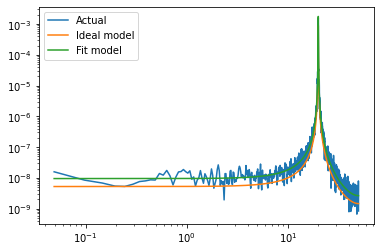

In [243]:
plt.loglog(f, p, label="Actual")
ph = 2 * np.pi * f / fs
denom = np.abs(1 - a1 * np.exp(-1j * ph) - a2 * np.exp(-2j * ph))
plt.loglog(f, s ** 2 / fs / denom ** 2, label=f"Ideal model")
plt.loglog(f, 10 ** res.best_fit, label=f"Fit model")
plt.legend()

In [256]:
np.sqrt(np.mean(100 * p[f > 100 / 3]))

0.0006351551266425559